In [32]:
import numpy as np
import pygamma as pg
import nmrglue as ng
from scipy import fftpack

In [2]:
from matplotlib import pyplot as plt

In [3]:
%matplotlib inline

In [4]:
sys=pg.spin_system()     # define the system, read in
sys.read("cs_1_100.sys") # from disk

print( sys)

Spin Index :      0      
Isotope    :      1H     
Momentum   :     1/2     
Shifts     :     0.00 Hz 
           :     0.25 ppm
Omega      :   400.00 MHz



### Create 1D spectrum

In [5]:
dt1 = 0.001 # t1 time increment
dt2 = 0.001 # t2 time increment
t1pts = 256 # points on t1 axis
t2pts = 256 # points on t2 axis

In [6]:
H = pg.Hcs(sys)                                               # // Hamiltonian, weak coupling
detect = pg.gen_op(pg.Fp(sys))                                  # // F+ for detection operator
fid = pg.row_vector(t2pts)                                    #block_1D tmp(t2pts); // 1D-data block storage


In [7]:
sigma0 = pg.sigma_eq(sys)                      # // equilibrium density matrix
sigma1 = pg.Iypuls(sys, sigma0, 90)  
sigma1 = pg.evolve(sigma1, H, 1*dt2)

In [8]:
pg.FID(sigma1,detect,H,dt2,t2pts,fid)

In [9]:
pg.exponential_multiply(fid,-5)

In [10]:
spec = fid.FFT()

In [11]:
npspec = spec.toNParray()

In [12]:
udic = {'ndim': 1,
         0: {'sw': 1/dt2,
          'complex': True,
          'obs': 400.0,
          'car': 0,
          'size': len(npspec),
          'label': '1H',
          'encoding': 'direct',
          'time': False,
          'freq': True}}

In [13]:
uc0 = ng.fileiobase.unit_conversion(udic[0]['size'],udic[0]['complex'], udic[0]['sw'], udic[0]['obs'], udic[0]['car'])

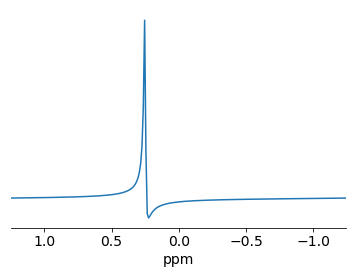

In [14]:
plt.plot(uc0.ppm_scale(), npspec.real)
plt.xlim(uc0.ppm_limits())
plt.xlabel('ppm', fontsize=14)
plt.yticks([])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=14)


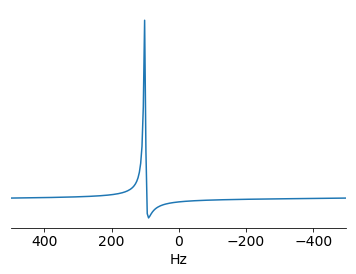

In [15]:
plt.plot(uc0.hz_scale(), npspec.real)
plt.xlim(uc0.hz_limits())
plt.xlabel('Hz', fontsize=14)
plt.yticks([])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=14)

### 2D States Example

### Perform pulse sequence

In [16]:
Hcs = pg.Hcs(sys)                                               # // Hamiltonian,chemical shift

detect = pg.gen_op(pg.Fp(sys))                                  # // F+ for detection operator

In [17]:
fidp_list = []

sigma0 = pg.sigma_eq(sys)                      # // equilibrium density matrix

for t1 in range(t1pts):
    fid = pg.row_vector(t2pts, pg.complex(0,0))

    sigma1 = pg.Iypuls(sys, sigma0, 90)  
    sigma1=pg.evolve(sigma1,H,t1*dt1)         #; // evolution during t1
    pg.FID(sigma1,detect,H,dt2,t2pts,fid)
    fidp_list.append(fid)

fidm_list = []
for t1 in range(t1pts):
    fid = pg.row_vector(t2pts, pg.complex(0,0))

    sigma1 = pg.Ixpuls(sys, sigma0, 90)  
    sigma1=pg.evolve(sigma1,H,t1*dt1)         #; // evolution during t1
    pg.FID(sigma1,detect,H,dt2,t2pts,fid)
    fidm_list.append(fid)

/home/eric/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


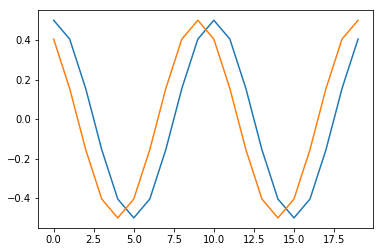

In [18]:
plt.plot(((fidp_list[0])[0:20]).toNParray())
plt.plot(((fidp_list[1])[0:20]).toNParray())

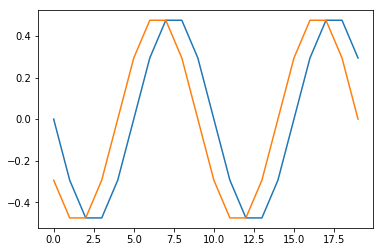

In [19]:
plt.plot(((fidm_list[0])[0:20]).toNParray())
plt.plot(((fidm_list[1])[0:20]).toNParray())

### Apply linebradening and FFT in direct dimension

In [20]:
for t1 in range(t1pts):
    pg.exponential_multiply(fidp_list[t1],-5)

In [21]:
for t1 in range(t1pts):
    pg.exponential_multiply(fidm_list[t1],-5)

In [28]:
specp = np.zeros((t1pts,t2pts), dtype=np.complex128)
specm = np.zeros((t1pts,t2pts), dtype=np.complex128)
for t1 in range(t1pts):
    specp[t1] = (fidm_list[t1].FFT()).toNParray()
    specm[t1] = (fidm_list[t1].FFT()).toNParray()


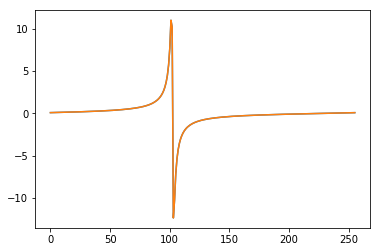

In [29]:
plt.plot(specp[0].real)
plt.plot(specm[0].real)

In [30]:
specpm = specp.real + 1j*specm.real

In [35]:
specpm2 = fftpack.fftshift(fftpack.fft(specpm, axis=0), axes=0)

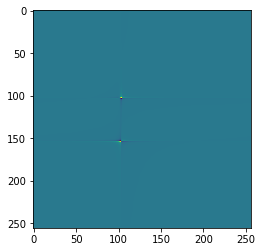

In [36]:
plt.imshow(specpm2.real)

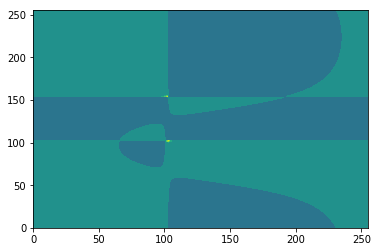

In [37]:
plt.contourf(specpm2.real)